# Creating the corpus.csv

In [5]:
import pandas as pd
import os

folder_path = "data/newari_data_archive"

filenames = []
texts = []
for file in os.listdir(folder_path):
    filenames.append(file)
    with open(os.path.join(folder_path, file), "r", encoding="utf-8") as f:
        content = f.read()
        content = content.replace("\n", " ")
        texts.append(content)

corpus = pd.DataFrame({
    "filename": filenames,
    "text": texts
})

corpus.to_csv("data/corpus.csv", index=False)

This one is faster.

In [11]:
from pathlib import Path
import pandas as pd

folder_path = Path("data/newari_data_archive")

files = list(folder_path.glob("*"))

corpus = pd.DataFrame({
    "filename": [f.name for f in files],
    # "text": [f.read_text(encoding="utf-8").replace("\n", " ") for f in files]
    "text": [f.read_text(encoding="utf-8") for f in files]
})

corpus.to_csv("data/corpus.csv", index=False)

# Building a rule based tokenizer

In [1]:
import pandas as pd
import re

In [2]:
corpus = pd.read_csv("data/corpus.csv")

In [22]:
_DEVANAGARI_PATTERN = re.compile(r'[\u0900-\u0963\u0966-\u097F]+')

with open("data/stopwords.txt", "r", encoding="utf-8") as f:
    _STOPWORDS = set(line.strip() for line in f)

def tokenize(text):
    # extract words but ignore । and ॥
    words = _DEVANAGARI_PATTERN.findall(text)
    normalized = [word.replace("\u0940", "\u093F").replace("\u0942", "\u0941") for word in words]
    return [word for word in normalized if word not in _STOPWORDS]

# Computing Term Frequency

In [21]:
from collections import Counter

def compute_term_frequency(documents):
    term_frequency = Counter()
    for document in documents:
        term_frequency.update(tokenize(document))

    # return term_frequency.most_common()
    return sorted(term_frequency.items(), key=lambda x: x[0])

# term_frequencies = compute_term_frequency(corpus['text'].tolist())

# df = pd.DataFrame(term_frequencies, columns=['term', 'frequency'])
# df.to_csv("data/term_frequency_alphabetically.csv", index=False)

In [10]:
# df = pd.read_csv("data/term_frequency.csv")
# df.shape

(246461, 2)

In [18]:
# df = df[df['frequency'] > 3000]
# df.shape

(438, 2)

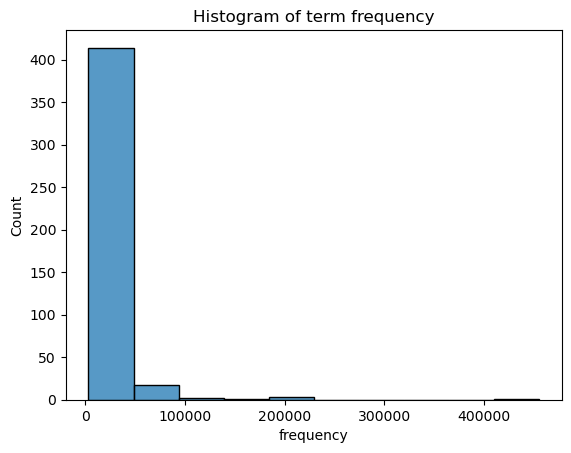

In [19]:
# import seaborn as sns
# import matplotlib.pyplot as plt
#
# sns.histplot(df, x="frequency", bins=10, kde=False)
# plt.title("Histogram of term frequency")
# plt.show()

In [20]:
# df.to_csv("data/stopwords.csv", index=False)

# Term weighing for the documents using tf.idf

In [24]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(
    tokenizer=tokenize,
    use_idf=True,
    sublinear_tf=True,
)

tfidf_matrix = vectorizer.fit_transform(corpus["text"].tolist())
tfidf_matrix.shape

(80380, 246435)

In [49]:
print(type(tfidf_matrix))

<class 'scipy.sparse._csr.csr_matrix'>


# Building the inverted index using the tfidf matrix

In [38]:
def build_inverted_index(tfidf_matrix, vectorizer):
    from collections import defaultdict
    coo = tfidf_matrix.tocoo()
    inverted_index = defaultdict(list)
    terms = vectorizer.get_feature_names_out()

    for docid, termid, weight in zip(coo.row, coo.col, coo.data):
        inverted_index[terms[termid]].append((docid, weight))

    for postings in inverted_index.values():
        postings.sort(key=lambda x: x[1], reverse=True)

    return inverted_index

inverted_index = build_inverted_index(tfidf_matrix, vectorizer)

<class 'numpy.ndarray'>
246435


# Implementing the search functionality

In [39]:
from sklearn.metrics.pairwise import cosine_similarity

def search(query, tfidf_matrix, vectorizer, top_k=10):
    query_vector = vectorizer.transform([query])
    similarities = cosine_similarity(query_vector, tfidf_matrix)[0]
    top_indices = similarities.argsort()[-top_k:][::-1]
    return [(idx, similarities[idx]) for idx in top_indices]

# Saving the vectorizer and tfidf matrix

In [50]:
import pickle
import scipy.sparse

# Save the vectorizer
with open('models/vectorizer.pkl', 'wb') as f:
    pickle.dump(vectorizer, f)

# Save the TF-IDF matrix
scipy.sparse.save_npz('models/tfidf_matrix.npz', tfidf_matrix)

# Testing the search function

In [48]:
output = search("नेपाल भारतया", tfidf_matrix, vectorizer, top_k=3)

for docid, score in output:
    print("Document id: " + str(docid) + " with score " + str(score) + "\n")
    print(corpus['text'].iloc[docid])
    print("\n----------------\n")

Document id: 74680 with score 0.22677464279830878



लिधंसा

स्वयादिसँ 
 http://dpe.nic.in/survey01/vol1/APENDIX3.pdf

भारतया अर्थतन्त्र


----------------


Document id: 74117 with score 0.21997317352807302

नेपाल सम्बतया छन्हु ख। थ्व दिं खुनु जूगु घटना थ्व कथं दु-

घटना
 नेपाल लिपि गुथिया पलिस्था

तजिलजि

स्वयादिसँ
 नेपाल सम्बत

दसमि


----------------


Document id: 15369 with score 0.20337000283178944

महिन्द्र मल्लयात नेपाल भाषाया आदिकवि कथं नालातःगु दु ।

नेपाल भाषा साहित्य


----------------


